In [1]:
# Autosklearn seems to throw a ton of warnings by default
import warnings
warnings.filterwarnings('ignore')

from main import train_autoencoder
import numpy as np
from torch import nn
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
class Preprocessor():
    def __init__(self, X_train, y_train):

        self.earliest_date = np.datetime64('2015-01-04')
        self.mean_price = np.mean(y_train)

        regions = np.array(X_train[:, -1], dtype=str)
        regions_list = list(set(regions))

        # For each region, calculate a 'wealth' factor (difference in it's mean price to the mean price of all regions)
        self.region_wealths = dict()

        for region in regions_list:
            region_ids = np.where(regions == region)[0] 
            region_mean = np.mean(y_train[region_ids])
            self.region_wealths[region] = region_mean - self.mean_price

    def preprocess_X(self, X):
        # ------ 
        # Turn datetime into an int that denotes the time in weeks since 'earliest date'
        weeks = np.array(X[:, 0], dtype=np.datetime64)
        weeks = weeks - self.earliest_date
        weeks = weeks / np.timedelta64(7, 'D')

        # ------ 
        # We apply a logarithm to most features and drop the features 'bags' and 'year' since they are redundant
        total_volume = np.array(X[:, 1], dtype=float)
        total_volume = np.clip(total_volume, a_min=0.1, a_max=None)
        total_volume = np.log(total_volume)

        plu_4046 = np.array(X[:, 2], dtype=float)
        plu_4046 = np.clip(plu_4046, a_min=0.1, a_max=None)
        plu_4046 = np.log(plu_4046)

        plu_4225 = np.array(X[:, 3], dtype=float)
        plu_4225 = np.clip(plu_4225, a_min=0.1, a_max=None)
        plu_4225 = np.log(plu_4225)

        plu_4770 = np.array(X[:, 4], dtype=float)
        plu_4770 = np.clip(plu_4770, a_min=0.1, a_max=None)
        plu_4770 = np.log(plu_4770)
        
        useless_1 = np.array(X[:, 5], dtype=float)
        useless_1 = np.clip(useless_1, a_min=0.1, a_max=None)
        useless_1 = np.log(useless_1)

        sbags = np.array(X[:, 6], dtype=float)
        sbags = np.clip(sbags, a_min=0.1, a_max=None)
        sbags = np.log(sbags)

        lbags = np.array(X[:, 7], dtype=float)
        lbags = np.clip(lbags, a_min=0.1, a_max=None)
        lbags = np.log(lbags)

        xlbags = np.array(X[:, 8], dtype=float)
        xlbags = np.clip(xlbags, a_min=0.1, a_max=None)
        xlbags = np.log(xlbags)

        # ------ 
        # Turn categorical feature into bool array that indicates if the avocado is conventional or organic
        organic = X[:, 9] == b'organic'
        organic = organic.astype(float)
        
        year = np.array(X[:, 10], dtype=float)

        # ------ 
        # For the regions, we heavily decrease out search space by assuming the biggest relevant information in the region is some overall 'wealth' factor.
        # While this is a pretty bold assumption, it decreases this feature by 51 dimensions.
        regions = np.array(X[:, -1], dtype=str)

        wealth = np.zeros_like(regions, dtype=float)
        for i in range(wealth.shape[0]):
            wealth[i] = self.region_wealths[regions[i]]
        wealth = wealth.astype(float)
        
        output_X = np.vstack([weeks, total_volume, plu_4046, plu_4225, plu_4770, useless_1, sbags, year, lbags, xlbags, organic, wealth]).T
        return output_X

In [3]:
X = np.genfromtxt('data/traindata.csv', delimiter=',', dtype=None)
Y = np.genfromtxt('data/traindata_label.csv', delimiter=',')

# Cut off header and turn tuples into list
X = np.array([list(line) for line in X[1:]])
Y = Y[1:]

In [4]:
ids = np.arange(len(Y))
np.random.shuffle(ids)
X = X[ids]
Y = Y[ids]

train_x = X[:12000]
train_y = Y[:12000]

test_x = X[12000:]
test_y = Y[12000:]

In [5]:
preprocessor = Preprocessor(train_x, train_y)

train_x = preprocessor.preprocess_X(train_x)
test_x = preprocessor.preprocess_X(test_x)

In [6]:
preprocessor = preprocessing.MinMaxScaler(feature_range=(0, 1))
preprocessor.fit(train_x)

train_x = preprocessor.transform(train_x)
test_x = preprocessor.transform(test_x)

In [7]:
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
test_x = torch.from_numpy(test_x).type(torch.FloatTensor)

train_y = torch.from_numpy(train_y).type(torch.LongTensor)
test_y = torch.from_numpy(test_y).type(torch.LongTensor)

In [8]:
train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

In [11]:
num_epochs = 60

_____
0
Epoch 0, latent size 12. LOSS: train 0.0218 test 0.0129.
Epoch 1, latent size 12. LOSS: train 0.0093 test 0.0067.
Epoch 2, latent size 12. LOSS: train 0.0052 test 0.0042.
Epoch 3, latent size 12. LOSS: train 0.0035 test 0.0031.
Epoch 4, latent size 12. LOSS: train 0.0027 test 0.0024.
Epoch 5, latent size 12. LOSS: train 0.0021 test 0.0019.
Epoch 6, latent size 12. LOSS: train 0.0017 test 0.0016.
Epoch 7, latent size 12. LOSS: train 0.0015 test 0.0014.
Epoch 8, latent size 12. LOSS: train 0.0013 test 0.0012.
Epoch 9, latent size 12. LOSS: train 0.0011 test 0.0010.
Epoch 10, latent size 12. LOSS: train 0.0009 test 0.0009.
Epoch 11, latent size 12. LOSS: train 0.0008 test 0.0008.
Epoch 12, latent size 12. LOSS: train 0.0007 test 0.0007.
Epoch 13, latent size 12. LOSS: train 0.0006 test 0.0006.
Epoch 14, latent size 12. LOSS: train 0.0005 test 0.0005.
Epoch 15, latent size 12. LOSS: train 0.0005 test 0.0004.
Epoch 16, latent size 12. LOSS: train 0.0004 test 0.0004.
Epoch 17, latent

Epoch 141, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 142, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 143, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 144, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 145, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 146, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 147, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 148, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 149, latent size 10. LOSS: train 0.0006 test 0.0007.
Epoch 150, latent size 10. LOSS: train 0.0006 test 0.0007.
Epoch 151, latent size 10. LOSS: train 0.0006 test 0.0006.
Epoch 152, latent size 10. LOSS: train 0.0006 test 0.0006.
Epoch 153, latent size 10. LOSS: train 0.0006 test 0.0006.
Epoch 154, latent size 10. LOSS: train 0.0006 test 0.0006.
Epoch 155, latent size 10. LOSS: train 0.0006 test 0.0006.
Epoch 156, latent size 10. LOSS: train 0.0006 test 0.0006.
Epoch 157, latent size 10. LOSS: train 0.0006 test 0.000

Epoch 282, latent size 8. LOSS: train 0.0011 test 0.0011.
Epoch 283, latent size 8. LOSS: train 0.0011 test 0.0011.
Epoch 284, latent size 8. LOSS: train 0.0011 test 0.0011.
Epoch 285, latent size 8. LOSS: train 0.0011 test 0.0011.
Epoch 286, latent size 8. LOSS: train 0.0011 test 0.0010.
Epoch 287, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 288, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 289, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 290, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 291, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 292, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 293, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 294, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 295, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 296, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 297, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 298, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 299, lat

Epoch 424, latent size 5. LOSS: train 0.0041 test 0.0041.
Epoch 425, latent size 5. LOSS: train 0.0040 test 0.0040.
Epoch 426, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 427, latent size 5. LOSS: train 0.0039 test 0.0038.
Epoch 428, latent size 5. LOSS: train 0.0038 test 0.0038.
Epoch 429, latent size 5. LOSS: train 0.0038 test 0.0038.
Epoch 430, latent size 5. LOSS: train 0.0038 test 0.0037.
Epoch 431, latent size 5. LOSS: train 0.0037 test 0.0037.
Epoch 432, latent size 5. LOSS: train 0.0037 test 0.0037.
Epoch 433, latent size 5. LOSS: train 0.0037 test 0.0036.
Epoch 434, latent size 5. LOSS: train 0.0037 test 0.0036.
Epoch 435, latent size 5. LOSS: train 0.0036 test 0.0036.
Epoch 436, latent size 5. LOSS: train 0.0036 test 0.0036.
Epoch 437, latent size 5. LOSS: train 0.0036 test 0.0036.
Epoch 438, latent size 5. LOSS: train 0.0036 test 0.0035.
Epoch 439, latent size 5. LOSS: train 0.0036 test 0.0035.
Epoch 440, latent size 5. LOSS: train 0.0036 test 0.0035.
Epoch 441, lat

Epoch 566, latent size 3. LOSS: train 0.0090 test 0.0091.
Epoch 567, latent size 3. LOSS: train 0.0090 test 0.0091.
Epoch 568, latent size 3. LOSS: train 0.0089 test 0.0090.
Epoch 569, latent size 3. LOSS: train 0.0089 test 0.0090.
Epoch 570, latent size 3. LOSS: train 0.0089 test 0.0089.
Epoch 571, latent size 3. LOSS: train 0.0089 test 0.0089.
Epoch 572, latent size 3. LOSS: train 0.0088 test 0.0089.
Epoch 573, latent size 3. LOSS: train 0.0088 test 0.0089.
Epoch 574, latent size 3. LOSS: train 0.0088 test 0.0088.
Epoch 575, latent size 3. LOSS: train 0.0088 test 0.0088.
Epoch 576, latent size 3. LOSS: train 0.0087 test 0.0088.
Epoch 577, latent size 3. LOSS: train 0.0087 test 0.0088.
Epoch 578, latent size 3. LOSS: train 0.0087 test 0.0088.
Epoch 579, latent size 3. LOSS: train 0.0087 test 0.0087.
Epoch 580, latent size 3. LOSS: train 0.0087 test 0.0087.
Epoch 581, latent size 3. LOSS: train 0.0086 test 0.0087.
Epoch 582, latent size 3. LOSS: train 0.0086 test 0.0087.
Epoch 583, lat

Epoch 708, latent size 1. LOSS: train 0.0340 test 0.0343.
Epoch 709, latent size 1. LOSS: train 0.0340 test 0.0343.
Epoch 710, latent size 1. LOSS: train 0.0340 test 0.0343.
Epoch 711, latent size 1. LOSS: train 0.0339 test 0.0343.
Epoch 712, latent size 1. LOSS: train 0.0339 test 0.0343.
Epoch 713, latent size 1. LOSS: train 0.0339 test 0.0343.
Epoch 714, latent size 1. LOSS: train 0.0339 test 0.0343.
Epoch 715, latent size 1. LOSS: train 0.0339 test 0.0343.
Epoch 716, latent size 1. LOSS: train 0.0339 test 0.0343.
Epoch 717, latent size 1. LOSS: train 0.0339 test 0.0343.
Epoch 718, latent size 1. LOSS: train 0.0339 test 0.0343.


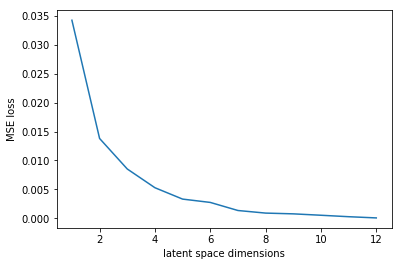

_____
1
Epoch 0, latent size 12. LOSS: train 0.0218 test 0.0129.
Epoch 1, latent size 12. LOSS: train 0.0093 test 0.0067.
Epoch 2, latent size 12. LOSS: train 0.0053 test 0.0042.
Epoch 3, latent size 12. LOSS: train 0.0035 test 0.0031.
Epoch 4, latent size 12. LOSS: train 0.0027 test 0.0024.
Epoch 5, latent size 12. LOSS: train 0.0021 test 0.0019.
Epoch 6, latent size 12. LOSS: train 0.0017 test 0.0016.
Epoch 7, latent size 12. LOSS: train 0.0015 test 0.0014.
Epoch 8, latent size 12. LOSS: train 0.0013 test 0.0012.
Epoch 9, latent size 12. LOSS: train 0.0011 test 0.0010.
Epoch 10, latent size 12. LOSS: train 0.0009 test 0.0009.
Epoch 11, latent size 12. LOSS: train 0.0008 test 0.0008.
Epoch 12, latent size 12. LOSS: train 0.0007 test 0.0007.
Epoch 13, latent size 12. LOSS: train 0.0006 test 0.0006.
Epoch 14, latent size 12. LOSS: train 0.0005 test 0.0005.
Epoch 15, latent size 12. LOSS: train 0.0005 test 0.0004.
Epoch 16, latent size 12. LOSS: train 0.0004 test 0.0004.
Epoch 17, latent

Epoch 141, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 142, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 143, latent size 10. LOSS: train 0.0004 test 0.0005.
Epoch 144, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 145, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 146, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 147, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 148, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 149, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 150, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 151, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 152, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 153, latent size 10. LOSS: train 0.0003 test 0.0004.
Epoch 154, latent size 10. LOSS: train 0.0003 test 0.0004.
Epoch 155, latent size 10. LOSS: train 0.0003 test 0.0003.
Epoch 156, latent size 10. LOSS: train 0.0003 test 0.0003.
Epoch 157, latent size 10. LOSS: train 0.0003 test 0.000

Epoch 282, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 283, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 284, latent size 8. LOSS: train 0.0010 test 0.0009.
Epoch 285, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 286, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 287, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 288, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 289, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 290, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 291, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 292, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 293, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 294, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 295, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 296, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 297, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 298, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 299, lat

Epoch 424, latent size 5. LOSS: train 0.0053 test 0.0052.
Epoch 425, latent size 5. LOSS: train 0.0052 test 0.0051.
Epoch 426, latent size 5. LOSS: train 0.0052 test 0.0051.
Epoch 427, latent size 5. LOSS: train 0.0051 test 0.0050.
Epoch 428, latent size 5. LOSS: train 0.0051 test 0.0050.
Epoch 429, latent size 5. LOSS: train 0.0050 test 0.0049.
Epoch 430, latent size 5. LOSS: train 0.0050 test 0.0049.
Epoch 431, latent size 5. LOSS: train 0.0049 test 0.0048.
Epoch 432, latent size 5. LOSS: train 0.0049 test 0.0048.
Epoch 433, latent size 5. LOSS: train 0.0048 test 0.0048.
Epoch 434, latent size 5. LOSS: train 0.0048 test 0.0047.
Epoch 435, latent size 5. LOSS: train 0.0048 test 0.0047.
Epoch 436, latent size 5. LOSS: train 0.0047 test 0.0046.
Epoch 437, latent size 5. LOSS: train 0.0047 test 0.0046.
Epoch 438, latent size 5. LOSS: train 0.0046 test 0.0046.
Epoch 439, latent size 5. LOSS: train 0.0046 test 0.0045.
Epoch 440, latent size 5. LOSS: train 0.0046 test 0.0045.
Epoch 441, lat

Epoch 566, latent size 3. LOSS: train 0.0185 test 0.0185.
Epoch 567, latent size 3. LOSS: train 0.0185 test 0.0185.
Epoch 568, latent size 3. LOSS: train 0.0185 test 0.0185.
Epoch 569, latent size 3. LOSS: train 0.0185 test 0.0185.
Epoch 570, latent size 3. LOSS: train 0.0185 test 0.0185.
Epoch 571, latent size 3. LOSS: train 0.0185 test 0.0184.
Epoch 572, latent size 3. LOSS: train 0.0185 test 0.0184.
Epoch 573, latent size 3. LOSS: train 0.0185 test 0.0184.
Epoch 574, latent size 3. LOSS: train 0.0184 test 0.0184.
Epoch 575, latent size 3. LOSS: train 0.0184 test 0.0184.
Epoch 576, latent size 3. LOSS: train 0.0184 test 0.0184.
Epoch 577, latent size 3. LOSS: train 0.0184 test 0.0184.
Epoch 578, latent size 3. LOSS: train 0.0184 test 0.0184.
Epoch 579, latent size 3. LOSS: train 0.0184 test 0.0184.
Epoch 580, latent size 3. LOSS: train 0.0184 test 0.0184.
Epoch 581, latent size 3. LOSS: train 0.0184 test 0.0183.
Epoch 582, latent size 3. LOSS: train 0.0184 test 0.0183.
Epoch 583, lat

Epoch 708, latent size 1. LOSS: train 0.0507 test 0.0500.
Epoch 709, latent size 1. LOSS: train 0.0505 test 0.0498.
Epoch 710, latent size 1. LOSS: train 0.0502 test 0.0496.
Epoch 711, latent size 1. LOSS: train 0.0500 test 0.0494.
Epoch 712, latent size 1. LOSS: train 0.0498 test 0.0492.
Epoch 713, latent size 1. LOSS: train 0.0496 test 0.0490.
Epoch 714, latent size 1. LOSS: train 0.0494 test 0.0488.
Epoch 715, latent size 1. LOSS: train 0.0492 test 0.0486.
Epoch 716, latent size 1. LOSS: train 0.0490 test 0.0485.
Epoch 717, latent size 1. LOSS: train 0.0488 test 0.0483.
Epoch 718, latent size 1. LOSS: train 0.0487 test 0.0482.


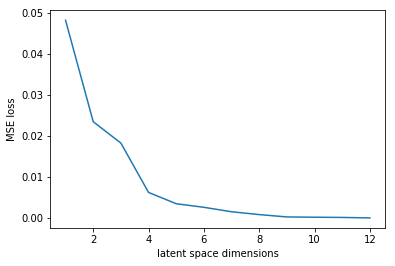

_____
2
Epoch 0, latent size 12. LOSS: train 0.0218 test 0.0129.
Epoch 1, latent size 12. LOSS: train 0.0093 test 0.0067.
Epoch 2, latent size 12. LOSS: train 0.0053 test 0.0042.
Epoch 3, latent size 12. LOSS: train 0.0035 test 0.0030.
Epoch 4, latent size 12. LOSS: train 0.0027 test 0.0024.
Epoch 5, latent size 12. LOSS: train 0.0021 test 0.0019.
Epoch 6, latent size 12. LOSS: train 0.0017 test 0.0016.
Epoch 7, latent size 12. LOSS: train 0.0015 test 0.0014.
Epoch 8, latent size 12. LOSS: train 0.0013 test 0.0012.
Epoch 9, latent size 12. LOSS: train 0.0011 test 0.0010.
Epoch 10, latent size 12. LOSS: train 0.0009 test 0.0009.
Epoch 11, latent size 12. LOSS: train 0.0008 test 0.0008.
Epoch 12, latent size 12. LOSS: train 0.0007 test 0.0007.
Epoch 13, latent size 12. LOSS: train 0.0006 test 0.0006.
Epoch 14, latent size 12. LOSS: train 0.0005 test 0.0005.
Epoch 15, latent size 12. LOSS: train 0.0005 test 0.0004.
Epoch 16, latent size 12. LOSS: train 0.0004 test 0.0004.
Epoch 17, latent

Epoch 141, latent size 10. LOSS: train 0.0010 test 0.0010.
Epoch 142, latent size 10. LOSS: train 0.0010 test 0.0010.
Epoch 143, latent size 10. LOSS: train 0.0010 test 0.0010.
Epoch 144, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 145, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 146, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 147, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 148, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 149, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 150, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 151, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 152, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 153, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 154, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 155, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 156, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 157, latent size 10. LOSS: train 0.0008 test 0.000

Epoch 282, latent size 8. LOSS: train 0.0011 test 0.0011.
Epoch 283, latent size 8. LOSS: train 0.0010 test 0.0011.
Epoch 284, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 285, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 286, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 287, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 288, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 289, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 290, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 291, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 292, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 293, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 294, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 295, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 296, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 297, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 298, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 299, lat

Epoch 424, latent size 5. LOSS: train 0.0040 test 0.0041.
Epoch 425, latent size 5. LOSS: train 0.0040 test 0.0040.
Epoch 426, latent size 5. LOSS: train 0.0040 test 0.0040.
Epoch 427, latent size 5. LOSS: train 0.0040 test 0.0040.
Epoch 428, latent size 5. LOSS: train 0.0040 test 0.0040.
Epoch 429, latent size 5. LOSS: train 0.0040 test 0.0040.
Epoch 430, latent size 5. LOSS: train 0.0039 test 0.0040.
Epoch 431, latent size 5. LOSS: train 0.0039 test 0.0040.
Epoch 432, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 433, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 434, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 435, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 436, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 437, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 438, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 439, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 440, latent size 5. LOSS: train 0.0039 test 0.0039.
Epoch 441, lat

Epoch 566, latent size 3. LOSS: train 0.0105 test 0.0107.
Epoch 567, latent size 3. LOSS: train 0.0104 test 0.0106.
Epoch 568, latent size 3. LOSS: train 0.0104 test 0.0106.
Epoch 569, latent size 3. LOSS: train 0.0104 test 0.0106.
Epoch 570, latent size 3. LOSS: train 0.0104 test 0.0106.
Epoch 571, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 572, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 573, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 574, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 575, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 576, latent size 3. LOSS: train 0.0102 test 0.0104.
Epoch 577, latent size 3. LOSS: train 0.0102 test 0.0104.
Epoch 578, latent size 3. LOSS: train 0.0102 test 0.0104.
Epoch 579, latent size 3. LOSS: train 0.0102 test 0.0104.
Epoch 580, latent size 3. LOSS: train 0.0102 test 0.0104.
Epoch 581, latent size 3. LOSS: train 0.0101 test 0.0103.
Epoch 582, latent size 3. LOSS: train 0.0101 test 0.0103.
Epoch 583, lat

Epoch 708, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 709, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 710, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 711, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 712, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 713, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 714, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 715, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 716, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 717, latent size 1. LOSS: train 0.0440 test 0.0443.
Epoch 718, latent size 1. LOSS: train 0.0440 test 0.0443.


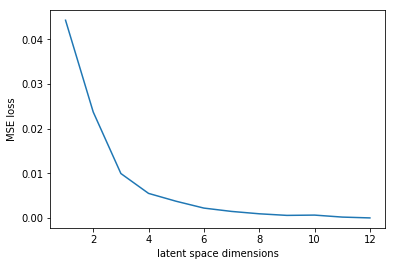

_____
3
Epoch 0, latent size 12. LOSS: train 0.0219 test 0.0130.
Epoch 1, latent size 12. LOSS: train 0.0093 test 0.0067.
Epoch 2, latent size 12. LOSS: train 0.0053 test 0.0042.
Epoch 3, latent size 12. LOSS: train 0.0036 test 0.0031.
Epoch 4, latent size 12. LOSS: train 0.0027 test 0.0024.
Epoch 5, latent size 12. LOSS: train 0.0021 test 0.0019.
Epoch 6, latent size 12. LOSS: train 0.0017 test 0.0016.
Epoch 7, latent size 12. LOSS: train 0.0015 test 0.0014.
Epoch 8, latent size 12. LOSS: train 0.0013 test 0.0012.
Epoch 9, latent size 12. LOSS: train 0.0011 test 0.0010.
Epoch 10, latent size 12. LOSS: train 0.0010 test 0.0009.
Epoch 11, latent size 12. LOSS: train 0.0008 test 0.0008.
Epoch 12, latent size 12. LOSS: train 0.0007 test 0.0007.
Epoch 13, latent size 12. LOSS: train 0.0006 test 0.0006.
Epoch 14, latent size 12. LOSS: train 0.0005 test 0.0005.
Epoch 15, latent size 12. LOSS: train 0.0005 test 0.0004.
Epoch 16, latent size 12. LOSS: train 0.0004 test 0.0004.
Epoch 17, latent

Epoch 141, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 142, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 143, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 144, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 145, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 146, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 147, latent size 10. LOSS: train 0.0005 test 0.0005.
Epoch 148, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 149, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 150, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 151, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 152, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 153, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 154, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 155, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 156, latent size 10. LOSS: train 0.0004 test 0.0004.
Epoch 157, latent size 10. LOSS: train 0.0004 test 0.000

Epoch 282, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 283, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 284, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 285, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 286, latent size 8. LOSS: train 0.0010 test 0.0010.
Epoch 287, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 288, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 289, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 290, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 291, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 292, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 293, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 294, latent size 8. LOSS: train 0.0009 test 0.0010.
Epoch 295, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 296, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 297, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 298, latent size 8. LOSS: train 0.0009 test 0.0009.
Epoch 299, lat

Epoch 424, latent size 5. LOSS: train 0.0112 test 0.0107.
Epoch 425, latent size 5. LOSS: train 0.0098 test 0.0094.
Epoch 426, latent size 5. LOSS: train 0.0087 test 0.0084.
Epoch 427, latent size 5. LOSS: train 0.0078 test 0.0075.
Epoch 428, latent size 5. LOSS: train 0.0070 test 0.0069.
Epoch 429, latent size 5. LOSS: train 0.0065 test 0.0064.
Epoch 430, latent size 5. LOSS: train 0.0060 test 0.0060.
Epoch 431, latent size 5. LOSS: train 0.0057 test 0.0057.
Epoch 432, latent size 5. LOSS: train 0.0054 test 0.0054.
Epoch 433, latent size 5. LOSS: train 0.0052 test 0.0052.
Epoch 434, latent size 5. LOSS: train 0.0050 test 0.0050.
Epoch 435, latent size 5. LOSS: train 0.0049 test 0.0049.
Epoch 436, latent size 5. LOSS: train 0.0047 test 0.0047.
Epoch 437, latent size 5. LOSS: train 0.0046 test 0.0046.
Epoch 438, latent size 5. LOSS: train 0.0045 test 0.0045.
Epoch 439, latent size 5. LOSS: train 0.0044 test 0.0044.
Epoch 440, latent size 5. LOSS: train 0.0043 test 0.0043.
Epoch 441, lat

Epoch 566, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 567, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 568, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 569, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 570, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 571, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 572, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 573, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 574, latent size 3. LOSS: train 0.0103 test 0.0105.
Epoch 575, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 576, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 577, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 578, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 579, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 580, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 581, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 582, latent size 3. LOSS: train 0.0102 test 0.0105.
Epoch 583, lat

Epoch 708, latent size 1. LOSS: train 0.0454 test 0.0452.
Epoch 709, latent size 1. LOSS: train 0.0454 test 0.0451.
Epoch 710, latent size 1. LOSS: train 0.0453 test 0.0451.
Epoch 711, latent size 1. LOSS: train 0.0453 test 0.0450.
Epoch 712, latent size 1. LOSS: train 0.0452 test 0.0450.
Epoch 713, latent size 1. LOSS: train 0.0452 test 0.0450.
Epoch 714, latent size 1. LOSS: train 0.0451 test 0.0449.
Epoch 715, latent size 1. LOSS: train 0.0451 test 0.0449.
Epoch 716, latent size 1. LOSS: train 0.0451 test 0.0449.
Epoch 717, latent size 1. LOSS: train 0.0450 test 0.0449.
Epoch 718, latent size 1. LOSS: train 0.0450 test 0.0448.


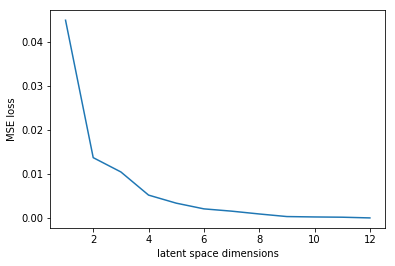

_____
4
Epoch 0, latent size 12. LOSS: train 0.0219 test 0.0129.
Epoch 1, latent size 12. LOSS: train 0.0094 test 0.0068.
Epoch 2, latent size 12. LOSS: train 0.0053 test 0.0042.
Epoch 3, latent size 12. LOSS: train 0.0036 test 0.0031.
Epoch 4, latent size 12. LOSS: train 0.0027 test 0.0024.
Epoch 5, latent size 12. LOSS: train 0.0021 test 0.0020.
Epoch 6, latent size 12. LOSS: train 0.0018 test 0.0016.
Epoch 7, latent size 12. LOSS: train 0.0015 test 0.0014.
Epoch 8, latent size 12. LOSS: train 0.0013 test 0.0012.
Epoch 9, latent size 12. LOSS: train 0.0011 test 0.0010.
Epoch 10, latent size 12. LOSS: train 0.0010 test 0.0009.
Epoch 11, latent size 12. LOSS: train 0.0008 test 0.0008.
Epoch 12, latent size 12. LOSS: train 0.0007 test 0.0007.
Epoch 13, latent size 12. LOSS: train 0.0006 test 0.0006.
Epoch 14, latent size 12. LOSS: train 0.0005 test 0.0005.
Epoch 15, latent size 12. LOSS: train 0.0005 test 0.0005.
Epoch 16, latent size 12. LOSS: train 0.0004 test 0.0004.
Epoch 17, latent

Epoch 141, latent size 10. LOSS: train 0.0010 test 0.0009.
Epoch 142, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 143, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 144, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 145, latent size 10. LOSS: train 0.0009 test 0.0009.
Epoch 146, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 147, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 148, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 149, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 150, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 151, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 152, latent size 10. LOSS: train 0.0008 test 0.0008.
Epoch 153, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 154, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 155, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 156, latent size 10. LOSS: train 0.0007 test 0.0007.
Epoch 157, latent size 10. LOSS: train 0.0007 test 0.000

Epoch 282, latent size 8. LOSS: train 0.0008 test 0.0008.
Epoch 283, latent size 8. LOSS: train 0.0007 test 0.0008.
Epoch 284, latent size 8. LOSS: train 0.0007 test 0.0008.
Epoch 285, latent size 8. LOSS: train 0.0007 test 0.0008.
Epoch 286, latent size 8. LOSS: train 0.0007 test 0.0008.
Epoch 287, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 288, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 289, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 290, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 291, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 292, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 293, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 294, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 295, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 296, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 297, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 298, latent size 8. LOSS: train 0.0007 test 0.0007.
Epoch 299, lat

Epoch 424, latent size 5. LOSS: train 0.0042 test 0.0040.
Epoch 425, latent size 5. LOSS: train 0.0040 test 0.0039.
Epoch 426, latent size 5. LOSS: train 0.0039 test 0.0038.
Epoch 427, latent size 5. LOSS: train 0.0038 test 0.0037.
Epoch 428, latent size 5. LOSS: train 0.0037 test 0.0036.
Epoch 429, latent size 5. LOSS: train 0.0037 test 0.0036.
Epoch 430, latent size 5. LOSS: train 0.0036 test 0.0036.
Epoch 431, latent size 5. LOSS: train 0.0036 test 0.0035.
Epoch 432, latent size 5. LOSS: train 0.0036 test 0.0035.
Epoch 433, latent size 5. LOSS: train 0.0035 test 0.0035.
Epoch 434, latent size 5. LOSS: train 0.0035 test 0.0034.
Epoch 435, latent size 5. LOSS: train 0.0035 test 0.0034.
Epoch 436, latent size 5. LOSS: train 0.0035 test 0.0034.
Epoch 437, latent size 5. LOSS: train 0.0035 test 0.0034.
Epoch 438, latent size 5. LOSS: train 0.0034 test 0.0034.
Epoch 439, latent size 5. LOSS: train 0.0034 test 0.0034.
Epoch 440, latent size 5. LOSS: train 0.0034 test 0.0034.
Epoch 441, lat

Epoch 566, latent size 3. LOSS: train 0.0112 test 0.0113.
Epoch 567, latent size 3. LOSS: train 0.0111 test 0.0113.
Epoch 568, latent size 3. LOSS: train 0.0110 test 0.0112.
Epoch 569, latent size 3. LOSS: train 0.0110 test 0.0111.
Epoch 570, latent size 3. LOSS: train 0.0109 test 0.0111.
Epoch 571, latent size 3. LOSS: train 0.0109 test 0.0110.
Epoch 572, latent size 3. LOSS: train 0.0108 test 0.0110.
Epoch 573, latent size 3. LOSS: train 0.0108 test 0.0110.
Epoch 574, latent size 3. LOSS: train 0.0107 test 0.0109.
Epoch 575, latent size 3. LOSS: train 0.0107 test 0.0109.
Epoch 576, latent size 3. LOSS: train 0.0106 test 0.0108.
Epoch 577, latent size 3. LOSS: train 0.0106 test 0.0108.
Epoch 578, latent size 3. LOSS: train 0.0105 test 0.0108.
Epoch 579, latent size 3. LOSS: train 0.0105 test 0.0107.
Epoch 580, latent size 3. LOSS: train 0.0105 test 0.0107.
Epoch 581, latent size 3. LOSS: train 0.0104 test 0.0107.
Epoch 582, latent size 3. LOSS: train 0.0104 test 0.0106.
Epoch 583, lat

Epoch 708, latent size 1. LOSS: train 0.0517 test 0.0510.
Epoch 709, latent size 1. LOSS: train 0.0515 test 0.0508.
Epoch 710, latent size 1. LOSS: train 0.0513 test 0.0506.
Epoch 711, latent size 1. LOSS: train 0.0511 test 0.0504.
Epoch 712, latent size 1. LOSS: train 0.0509 test 0.0502.
Epoch 713, latent size 1. LOSS: train 0.0507 test 0.0500.
Epoch 714, latent size 1. LOSS: train 0.0505 test 0.0498.
Epoch 715, latent size 1. LOSS: train 0.0503 test 0.0496.
Epoch 716, latent size 1. LOSS: train 0.0501 test 0.0495.
Epoch 717, latent size 1. LOSS: train 0.0499 test 0.0493.
Epoch 718, latent size 1. LOSS: train 0.0497 test 0.0491.


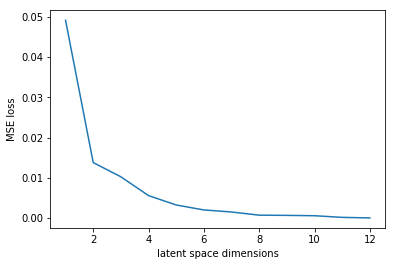

In [12]:
overall = []
for i in range(5):
    print("_____")
    print(i)
    model, history = train_autoencoder(train, test, 1, step_size=1, epochs_per_step=num_epochs, learning_rate=1e-4, weight_decay=1e-5, batch_size=64, verbose=False)
    result = []
    for i in range(num_epochs-2, num_epochs*12-1, num_epochs):
        result.append(history[:, 1][i])
    overall.append(result)
    x = [_ for _ in range(12, 0, -1)]

    # plt.title("loss with different latent space dimensions")
    plt.plot(x, np.array(result))
    plt.xlabel("latent space dimensions")
    plt.ylabel("MSE loss")
    plt.show()

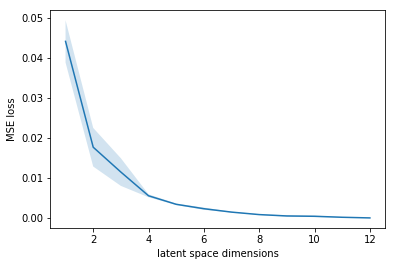

In [18]:
overall = np.array(overall)

stds = np.std(overall, axis=0)
means = np.mean(overall, axis=0)

plt.fill_between(x, means+stds, means-stds, alpha=0.2)
plt.plot(x, means)
plt.xlabel('latent space dimensions')
plt.ylabel('MSE loss')
plt.savefig('avocado')
plt.show()

In [ ]:
np.std(overall, axis=0)

In [ ]:
overall.shape

In [ ]:
x = [_ for _ in range(12, 0, -1)]

# plt.title("loss with different latent space dimensions")
plt.plot(x, np.array(result))
plt.xlabel("latent space dimensions")
plt.ylabel("MSE loss")
plt.savefig("MSE_per_dimensions_avocado")
plt.show()

In [ ]:
backup = result.copy()

In [ ]:
plt.plot(x[:32], result, label="restart comparable")
plt.plot(x[:32], iterative_backup[-32:], label="restart constant")
plt.plot(x[:32], backup[:32], label="iterative")

plt.xlabel("latent space dimensions")
plt.ylabel("MSE loss")

plt.legend()
plt.savefig("comparable_restart_vs_iterative")

plt.show()

In [ ]:
plt.plot(x[::-1], result[1:], label="restart")
plt.plot(x, backup, label="iterative")
plt.legend()
plt.xlabel("latent space dimensions")
plt.ylabel("MSE loss")
plt.savefig("restart_vs_iterative")
plt.show()

In [ ]:
iterative_backup = result.copy()